# Chapter 12 - Point / Feature Tracking

Given two images of consecutive frames, how do we find the warping that defines the mostion of a template form one image I<sub>0</sub> into a consecutive one, I<sub>1</sub>?

![Point tracking over a consecutive Frame](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_12/point_tracking_example.png)
*Figure 1: Point tracking over a consecutive Frame. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/11_tracking.pdf)*

Given the optical flow vectors of each individual pixel that is part of a template, we can calculate the Warping that is happening to the template image in each new frame. We first have to find the initial position and warping of the template, of course. This can be done using SIFT feature detection and matching. 

![Template tracking using Point Tracking](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_12/template_tracking.png)
*Figure 2: Template tracking using Point Tracking. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/11_tracking.pdf)*

There are two different approaches to track pixels between consecutive frames: **Block-based methods** and **Differential methods**. We will have a look at both of them, with focusing more on the faster differential based approaches. 

## Block-based methods
The block based methods are simple. Given a pixel, take a patch region around it in the first image I<sub>0</sub>, define a search radius r and try to find the same patch via SSD/SAD or NCC in the second image I<sub>1</sub> at the same location +- radius. 

This approach is of course very simple and easy to implement, but it works very well even on large motions, as long as the search region radius is defined large enough. However, this approach is computationally demanding for large images, since we have to search for a good correspondance in a r * r radius for every single pixel in I<sub>1</sub>.

## Differential methods
The differential methods examine a patch around the pixel and calculates the local brightness changes between two consecutive images. So there is no patch shifting involved, we just look at the same image region again in the consecutive frame. With finding out how the local brightness changes in each direction, we can estimate the relative motion between the two consecutive frames. However, we assume that the motion is at most a few pixels (temporal consistency), that the brightness does not change (would give an overall high local brightness change), as well as spatial coherency, e.g. the neighboring pixels belong to the same surface and therefore undergo the same motion. 

The differentiation method is quite simple. We want to find a motion vector (u, v) that describes the transformation from I<sub>0</sub> + (u, v) = I<sub>1</sub>, with a motion vector (u, v) that minimizes the difference between I<sub>0</sub> and I<sub>1</sub>. We can write this as the *Sum of Squared Difference* between the original image I<sub>0</sub>(x,y) and the new image I<sub>1</sub>(x+u, y+v). 

We can reformulate this equation and express the change in u and v direction as image derivatives, where I<sub>1x</sub> is the derivative of I<sub>1</sub> in x direction, and I<sub>1y</sub> is the derivative of I<sub>1</sub> in y direction. Since x and y are independent, I<sub>1</sub>(x+u, y+v) is exactly the same as I<sub>1</sub>(x, y) + I<sub>1x</sub> * u + I<sub>1y</sub> * v. We then write I<sub>0</sub> - I<sub>1</sub> as dI for convenience. We are left then left with the following equation:

![SSD of motion vector](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_12/motion_vector_ssd.png)
*Figure 3: SSD of motion vector. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/11_tracking.pdf)*

To minimize the SSD (further referred to as **E**), we can only optimize u and v since the two images are given. We can therefore optimize E with respecto to u and v individually. The optimum of the function is of course where the first partial derivative is =0, we therefore set both partial derivatives dE/du and dE/dv to zero and solve for u and v. 

![Partial derivatives for u,v that minimize the SSD](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_12/partial_derivatives_for_min_ssd.png)
*Figure 4: Partial derivatives for u,v that minimize the SSD. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/11_tracking.pdf)*

The resulting system of linar equations can e formulated as a matrix equation. The Matrix M is exactly the same as we have seen previously in Harris Corner Detection. 

![Matrix equation for min SSD](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_12/matrix_equation_for_min_ssd.png)
*Figure 5: Matrix equation for min SSD. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/11_tracking.pdf)*

For good results, the determinant of M *det(M)* must be non-zero, meaning its eigenvalues should be large, implying the region to contain strong and recognizable texture, which was the basis of the Harris Corner Detector. Again, if only one eigenvalue is large, we have observed an edge, if both are small we have a mostly flat, untextured region. 

![Influence of det(M) on feature quality](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_12/influence_of_determinant_on_feature_quality.png)
*Figure 6: Influence of det(M) on feature quality. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/11_tracking.pdf)*

### Aperture Problem
One problem we face when using Differential methods is the aperture problem. Given an edge, we can not determine in which direction it moved by just examining a small patch around it. Only if we increase the patch heavily until we see a corner, we can determine the direction of motion with certainty. 

![Aperture problem with a straight edge](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_12/aperture_problem.png)
*Figure 7: Aperture problem with a straight edge. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/11_tracking.pdf)*

### Optical Flow

Now that we can compute the relative motion between two consecutive pixels, we can also determine the optical flow, the relative motion between an observer (camera) and a subject. We can simply define a grid over the image and do pixelwise differnetial feature tracking. For each pixel, we'll get a motion vector (u,v) where the direction represents the motion direction and the magnitude the amount of movement. 

![Optical Flow](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_12/optical_flow.png)
*Figure 8: Optical Flow. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/11_tracking.pdf)*

## Template tracking (Lucas Kanade)

Given the initial pixels that belong to a template and a consecutive frame, we can now get motion vector for each pixel on our template. From this set of motion vectors, we now have to extract the warp of the template as a whole. We do so with using the Lucas Kanade detector. 

![Template Warping](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_12/template_warping.png)
*Figure 9: Template Warping. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/11_tracking.pdf)*

Given a Template image T(x), we take all the pixels from T(x) and warp them using a warper function W(x, P), where P is a well defined set of parameters. Depending on P, we can calculate different kinds of transformations, ranging from simple translations over affine transformations to projective transformations. The more complex the transformation, the more parameters P contains. The number of parameters needed are shown in the table below:

![2D transformations table with parameters P(a1, a2, .. an)](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_12/transformations_table.png)
*Figure 10: 2D transformations table with parameters P(a1, a2, .. an). [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/11_tracking.pdf)*

### Excuse: Jacobian

In order to understand the Lucas Kanade algorithm, we have to do a quick excursion into jacobians. Remember that a gradient of a function with mutiple variables is defined as the set of partial derivatives:

![Gradient of f(x1, x2, ..., xn)](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_12/gradiant_partial_derivatives.png)
*Figure 11: Gradient of f(x1, x2, ..., xn). [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/11_tracking.pdf)*

The jacobian now defines a matrix in which weach row represents a gradient of f as in the image above, and each new column defines  a new function f1, f2, ... fm. 

![Gradient of F(x1, x2, ..., xn) = Jacobian](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_12/jacobian.png)
*Figure 12: Gradient of F(x1, x2, ..., xn) = Jacobian. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/11_tracking.pdf)*

Why is this helpful? Well, let's see how we could take the derivative of an affine transformation W(x, p) with respect to p. W contains two functions f(u) and f(v), each with multiple parameters p. W is therefore a Vector of functions, F. We want to take the derivative with respect to each parameter p. We are therefore left with a Jacobian representing the derivative of W(x, p) with respect to the parameters p as a Matrix with two rows and n columns, assuming that n is the number of parameters p. Therefore, the derivative of W(x,p) is a jacobian. We will see this in action in the next paragraph.

![Jacobians of transformations](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_12/jacobians_of_transformations.png)
*Figure 13: Jacobians of transformations. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/11_tracking.pdf)*

### Template Warping

We have seen that, given a tempalte T(x), we want to find the parameters p for a function W(x,p) that transforms the template T(x) into the current Image I(w(x,p)): **T(x) = I(w(x,p)).**

The best parameters of p are the ones that minimize the difference between T(x) and I(w(x,p)), of course. We can formulate this again as an SSD, under the assumptions that we have no errors in the template image (no boarders with background), no occlusions (nothing in front of template), and, again, brightness consistency, temporal consistency and spatial coherency. 

The Lucas-Kanade Tracker now uses the numerical Gauss-Netwton method to minimize the SSD, so it applies the first-order approximations of the warp and then minimizes the SSD (referred to as  **E** again) iteratively. 

We assume that the initial state of the template is known (found using SIFT feature matching). What we seek is the increment of all parameters p that lead to the new image state, where p should minimize the SSD with W(x, p+dp). 
We can use the first order Taylor approximation to approximate the derivative of W(x, p+dp) linearly as follows: I(W(x, p+dp)) ~ I(W(x, p)) + dI * (dW/dp) * dp. Note that dI is the vector of partial image gradients [dI<sub>x</sub>, dI<sub>y</sub>] and (dW/dp) is the Jacobian of W(x,p). 

![Derivation of Lucas Kanade Algorithm](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_12/derivation_of_lukas_kanade.png)
*Figure 14: Derivation of Lucas Kanade Algorithm. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/11_tracking.pdf)*

We minimize the SSD by taking the derivative of E with respect to dp and evaluate it to zero, e.g. finding the minimum of dp. We finally get a formula for delta-p that includes the second Hessian Matrix of the warped image. 

![Delta p with Hessian Matrix](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_12/delta_p_hessian_matrix.png)
*Figure 15: Delta p with Hessian Matrix. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/11_tracking.pdf)*

The found dp is now the optimal step for the parameters p=p+xp to bring W(x,p) closer to an optimal transformation **T(x) = I(w(x,p))**.

Let's summarize the steps again:

- 1. Warp I(x) with W(x,p) to get I(W(x,p))
- 2. Compute the error I(W(x,p)) - I(x)
- 3. Compute the warped gradients: dI = [I<sub>x</sub>, I<sub>y</sub>] at W(x,p)
- 4. Evaluate the Jacobian of the warping: dW/dp
- 5. Compute the steepest gradient dI * (dW/dp)
- 6. Compute the Inverse Hessian: H<sup>-1</sup>
- 7. Multiply the steepest descent with the error
- 8. Compute dp
- 9. Update p = p + dp
- Repeat untill the solutions either do not change or we are in epsilon region of the optimal

![Lucas-Kanade Workflow steps 1-9](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_12/lucas-kanade-workflow.png)
*Figure 15: Lucas-Kanade Workflow steps 1-9. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/11_tracking.pdf)*

### Pyramid implementations
One problem we have still left is that the linear taylor approximation only holds if the intial estimate is close enough to the actual solutions. We can fix this by downsampling the image and applying the Lucas-Kanade there, since now a few pixels encode a larger distance. Wee can even form a pyramid of pictures in differenc sizes and compute Lucas-Kanade for each image size in the pyramid, giving us stability over large movements. 

### Tracking by detection of local image features
When we have two very different, non-consecutive frames, we can still use an adaption of Lucas-Kanade to estimate the relative warping between a template in both images. We do this by detecting and matching SIFT features and apply RANSAC to filter out the outliers. Then, we use these points as an input for Lucas Kanade. 

![SIFT Image feature tracking](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_12/sift_image_feature_tracking.png)
*Figure 16: SIFT Image feature tracking. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/11_tracking.pdf)*

# Python implementation

We'll now implement Lukas-Kanade Tracker (KLT) from scratch on our own. We'll first load an image and transform it using different transformation functions. We0ll then implement KLT to recover the transformations. 

To warp a given image I(x,y), we apply I(W(x,y,p)) with the warp W and parameters p. The warp matrix W is a 2x3 matrix of 6 parameters, so we can do affine warps only. 

We first write a function that, given input translations x,y and rotation a, returns us the corresponding Warp matrix. We will then write a second function that, given an image and a Warp matrix, returns a warped image for us. 

Populating the interactive namespace from numpy and matplotlib


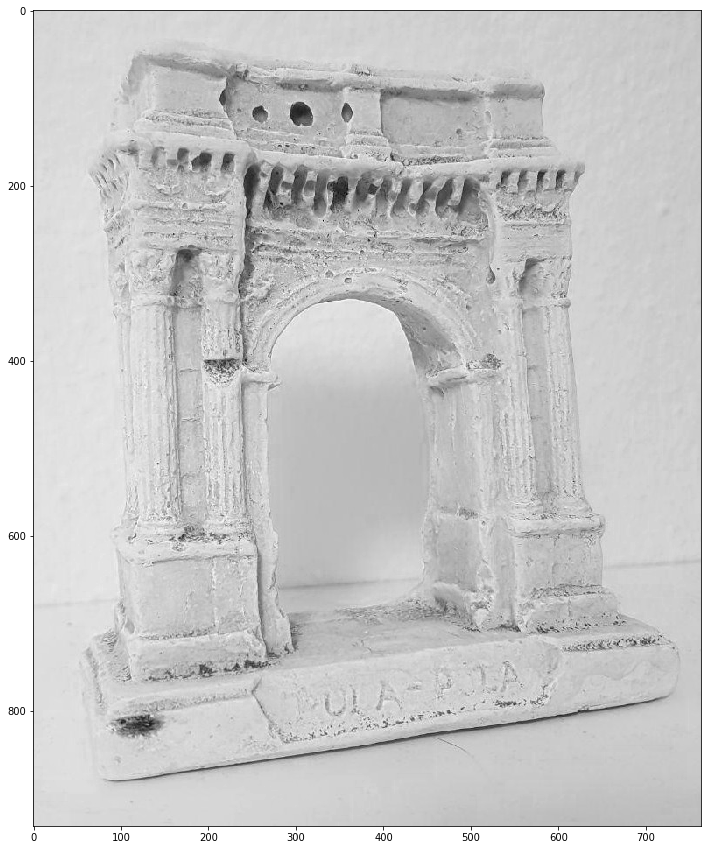

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 15)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Example image (since we have a greyscale image, reduce dimensionality down to 2)
img = mpimg.imread('img/chapter_12/img_1.jpg')[:,:,0] 
img = np.array(img, dtype=np.float32) / 255
plt.imshow(img, cmap='gray')
plt.show()

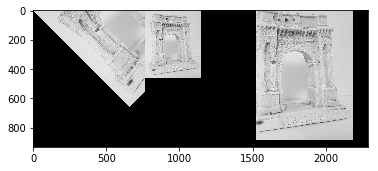

In [6]:
def getSimWarp(dx, dy, rotation, scale):
    rad = np.radians(rotation)
    M = np.array(
        [[ np.cos(rad), np.sin(rad), dy],
         [-np.sin(rad), np.cos(rad), dx]]
    )
    return M * scale

def warpImage(img, W):
    height, width = img.shape
    warped_img = np.zeros(img.shape, dtype=np.float32)
    for x in range(width):
        for y in range(height):
            new = np.matmul(W, np.array([y, x, 1]).T)
            nx, ny = int(new[1]), int(new[0])
            if(0 <= nx < width) and (0 <= ny < height):
                warped_img[y, x] = img[ny, nx]
    return warped_img

rot_45 = warpImage(img, getSimWarp(0, 0, 45, 1))
scale_2 = warpImage(img, getSimWarp(0, 0, 0, 2))
shift_100_50 = warpImage(img, getSimWarp(100, 50, 0, 1))

combined = np.concatenate((rot_45, scale_2, shift_100_50), axis=1)

plt.imshow(combined, cmap='gray')
plt.show()

The transformations we have made here are good, but not very helpful in our case. What we need is a function that extracts a patch from the image and warps it according to our function, but we can't do that with the functions we have just written. If we extract the patch first and warp it afterwards, we will have a mostly black image. If we first warp and then extract the patch, the warping is not applied correctly. So we need to write yet another function extracts a patch at position (u,v), applies the Warping with (u,v) as an origin and returns the patch. 

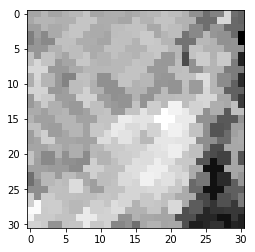

In [10]:
def getWarpedPatch(img, W, u, v, r):
    patch = np.zeros(shape=(2*r+1, 2*r+1), dtype=np.float32)
    height, width = img.shape
    
    for x in range(2*r+1):
        for y in range(2*r+1):
            new = np.matmul(W, np.array([y-r, x-r, 1]).T)
            nx, ny = u+int(new[1]), v+int(new[0])
            if(0 <= nx < width) and (0 <= ny < height):
                patch[y, x] = img[ny, nx]
    return patch

patch = getWarpedPatch(img, getSimWarp(100, 50, 45, 0.5), 500, 200, 15)
plt.imshow(patch, cmap='gray')
plt.show()

## Block-based method
Let's implement a brute-force, block-based method in finding the transformation between two patches. However, we will only deal with simple translation here since otherwise our brute forcer will take too long. 

Best fit at (u, v) = (-15, -10). Should be (u, v) = (-15, -10)


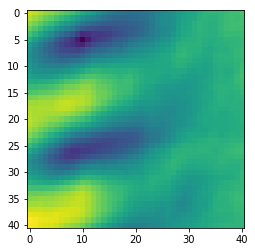

In [22]:
def blockSearch(ref_img, run_img, u, v, patch_radius, search_radius):
    W_template = getSimWarp(0, 0, 0, 1)
    template = getWarpedPatch(ref_img, W_template, u, v, patch_radius)
    
    ssds = np.zeros(shape=(2*search_radius+1, 2*search_radius+1), dtype=np.float32)
    min_ssd = 10000
    min_u, min_v = 0, 0
    for p5 in range(-search_radius, search_radius+1):
        for p6 in range(-search_radius, search_radius+1):
            W0 = getSimWarp(p5, p6, 0, 1)
            search = getWarpedPatch(run_img, W0, u, v, patch_radius)
            dist = search - template;
            ssd = np.sum(dist.flatten() ** 2)
            ssds[p5+search_radius, p6+search_radius] = ssd
            if ssd < min_ssd:
                min_ssd = ssd
                min_u, min_v = p5+search_radius, p6+search_radius
    return ssds, min_ssd, min_u-search_radius, min_v-search_radius

shift_15_10 = warpImage(img, getSimWarp(15, 10, 0, 1))
ssds, min_ssd, min_u, min_v = blockSearch(img, shift_15_10, u=550, v=200, patch_radius=15, search_radius=20)
print(f"Best fit at (u, v) = ({min_u}, {min_v}). Should be (u, v) = (-15, -10)")
plt.imshow(ssds)
plt.show()

## KLT
